The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# Adadelta
:label:`sec_adadelta`

([本节](https://github.com/d2l-ai/d2l-zh/tree/release/chapter_optimization)是机器翻译，欢迎[贡献](https://zh.d2l.ai/chapter_appendix/how-to-contribute.html)改进)

阿达德尔塔是 AdGRAD 的另一种变体（:numref:`sec_adagrad`）。主要区别在于它减少了学习率适应坐标的数量。此外，传统上它被称为没有学习率，因为它使用变化量本身作为未来变化的校准。该算法是在 :cite:`Zeiler.2012` 中提出的。鉴于迄今为止对以前的算法的讨论，这相当简单。

## 该算法

简而言之，Adelta 使用两个状态变量，$\mathbf{s}_t$ 用于存储梯度第二时刻的漏平均值，$\Delta\mathbf{x}_t$ 用于存储模型本身中参数变化第二时刻的漏平均值。请注意，为了与其他出版物和实现的兼容性，我们使用作者的原始符号和命名（没有其他真正理由为什么应该使用不同的希腊变量来表示在动量中用于相同用途的参数，即 Agrad、rMSProp 和 Adelta）。

以下是 Adelta 的技术细节。鉴于参数 du jour 是 $\rho$，我们获得了与 :numref:`sec_rmsprop` 类似的以下泄漏更新：

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

与 :numref:`sec_rmsprop` 的区别在于，我们使用重新缩放的渐变 $\mathbf{g}_t'$ 执行更新，即

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

那么，调整后的渐变 $\mathbf{g}_t'$ 是什么？我们可以按如下方式计算它：

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

其中 $\Delta \mathbf{x}_{t-1}$ 是重新缩放渐变的平方 $\mathbf{g}_t'$ 的泄漏平均值。我们将 $\Delta \mathbf{x}_{0}$ 初始化为 $0$，然后在每个步骤中使用 $\mathbf{g}_t'$ 更新它，即

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

和 $\epsilon$（例如 $10^{-5}$ 这样的小值）是为了保持数字稳定性而加入的。

## 实施

阿德尔塔需要为每个变量维护两个状态变量，即 $\mathbf{s}_t$ 和 $\Delta\mathbf{x}_t$。这将产生以下实施。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-place updates via [:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

对于每次参数更新，选择 $\rho = 0.9$ 相当于 10 个半衰期。这往往运行得很好。我们得到以下行为。


loss: 0.244, 0.015 sec/epoch


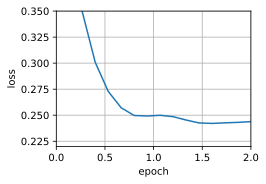

In [2]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

为了简洁实现，我们只需使用 `Trainer` 类中的 `adadelta` 算法。这将产生以下单行来进行更紧凑的调用。


loss: 0.243, 0.014 sec/epoch


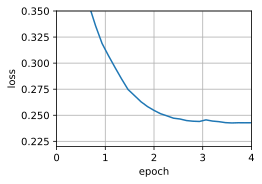

In [3]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

## 摘要

* Adelta 没有学习率参数。相反，它使用参数本身的变化率来调整学习率。
* Adelta 需要两个状态变量来存储梯度的第二个时刻和参数的变化。
* Adelta 使用泄漏的平均值来保持对适当统计数据的运行估计。

## 练习

1. 调整 $\rho$ 的值。会发生什么？
1. 展示如何在不使用 $\mathbf{g}_t'$ 的情况下实现算法。为什么这可能是个好主意？
1. Adelta 真的免费学习费用吗？你能找到打破 Adelta 的优化问题吗？
1. 将 Adelta 与 Agrad 和 RMS 道具进行比较，以讨论他们的收敛行为。


[Discussions](https://discuss.d2l.ai/t/1076)
